# Running Analysis
## Garmin data

### Imports

In [595]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

### loading

In [596]:
def load_data(file: str) -> pd.DataFrame:
    """
    param file: the name of the file with the running data
    :return: dataframe with the data
    """
    return pd.read_csv(file)
file = r"running_activities.csv"
data = load_data(file)
data.rename(columns = {"Time" : "Duration"}, inplace=True)
data.head()

,Activity Type,Date,Distance,Calories,Duration,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Pace,...,Total Descent,Avg Stride Length,Moving Time,Elapsed Time,Min Elevation,Max Elevation,Effort,Self Feel,Route Index,Place
0,Running,12/09/2022 21:00,7.01,464,0:41:59,0,0,169,192,6:00,...,55,0.99,0:41:54,0:41:59,50,80,9,3,1,Ein Vered
1,Running,08/09/2022 20:02,5.00,329,0:28:19,0,0,168,176,5:39,...,34,1.05,0:28:18,0:28:24,55,80,8,5,2,Ein Vered
2,Running,05/09/2022 20:50,7.01,460,0:40:02,0,0,169,175,5:43,...,57,1.04,0:39:56,0:40:02,50,80,8,5,1,Ein Vered
3,Running,03/09/2022 20:10,7.00,464,0:41:36,0,0,170,182,5:56,...,53,0.99,0:41:34,0:41:36,52,78,7,5,1,Ein Vered
4,Running,01/09/2022 20:42,5.01,331,0:28:57,0,0,167,175,5:47,...,35,1.03,0:28:50,0:28:57,50,79,8,5,3,Ein Vered


### Data pre-proccessing

#### filtering all the five km runs

In [597]:
epsilon_of_five = 0.1
five_km_runs = data.loc[(data["Distance"] >= 5-epsilon_of_five) & (data["Distance"] <= 5+epsilon_of_five)]
five_km_runs = five_km_runs.reset_index(drop=True)
five_km_runs.describe()

,Distance,Calories,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Stride Length,Route Index
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000
mean,5.005568,343.090909,122.806818,134.375000,166.170455,177.886364,1.047727,8.920455
std,0.011127,16.713706,75.767014,82.805868,2.496994,10.033773,0.065526,4.381837
min,5.000000,316.000000,0.000000,0.000000,157.000000,169.000000,0.700000,2.000000
25%,5.000000,329.000000,0.000000,0.000000,165.000000,173.000000,1.040000,4.750000
50%,5.000000,341.500000,167.000000,183.000000,167.000000,176.000000,1.060000,10.000000
75%,5.010000,353.500000,171.250000,186.000000,168.000000,178.000000,1.080000,11.000000
max,5.090000,396.000000,179.000000,195.000000,170.000000,227.000000,1.150000,18.000000


#### re-arranging the dataframe

In [598]:
five_km_runs["Dates"] = pd.to_datetime(five_km_runs["Date"]).dt.date
five_km_runs["Time"] = pd.to_datetime(five_km_runs["Date"]).dt.time
five_km_runs = five_km_runs.drop("Date", axis=1)
five_km_runs.rename(columns = {"Dates" : "Date"}, inplace=True)
cols = list(five_km_runs)
cols.insert(1, cols.pop(cols.index("Date")))
cols.insert(2, cols.pop(cols.index("Time")))
five_km_runs = five_km_runs.loc[:, cols]
five_km_runs.head(5)

,Activity Type,Date,Time,Distance,Calories,Duration,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,...,Total Descent,Avg Stride Length,Moving Time,Elapsed Time,Min Elevation,Max Elevation,Effort,Self Feel,Route Index,Place
0,Running,2022-08-09,20:02:00,5.00,329,0:28:19,0,0,168,176,...,34,1.05,0:28:18,0:28:24,55,80,8,5,2,Ein Vered
1,Running,2022-01-09,20:42:00,5.01,331,0:28:57,0,0,167,175,...,35,1.03,0:28:50,0:28:57,50,79,8,5,3,Ein Vered
2,Running,2022-08-25,18:58:00,5.01,321,0:28:10,0,0,167,173,...,45,1.06,0:27:40,0:28:10,53,81,7,5,4,Ein Vered
3,Running,2022-08-22,20:32:00,5.00,333,0:29:10,0,0,169,175,...,32,1.01,0:29:03,0:29:10,54,78,10,4,3,Ein Vered
4,Running,2022-08-18,18:45:00,5.01,328,0:28:11,0,0,168,176,...,43,1.06,0:28:06,0:28:11,53,81,9,5,3,Ein Vered


#### dividing the runs per season

In [599]:
summer_months = [5, 6, 7, 8, 9, 10]
winter_months = [1, 2, 3, 4, 11, 12]
summer_runs = pd.DataFrame()
winter_runs = pd.DataFrame()
for date in five_km_runs["Date"]:
    if date.month in summer_months:
        summer_runs = pd.concat([summer_runs, five_km_runs[five_km_runs["Date"] == date]], ignore_index=True, axis = 0)
    else:
        winter_runs = pd.concat([winter_runs, five_km_runs[five_km_runs["Date"] == date]], ignore_index=True, axis = 0)

In [600]:
# Summer runs preview
summer_runs = summer_runs.reset_index(drop=True).sort_values(by="Date")
summer_runs.describe()

,Distance,Calories,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Stride Length,Route Index
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,5.006727,343.581818,107.436364,116.781818,165.854545,178.927273,1.039091,8.709091
std,0.013341,18.708971,82.095871,89.120537,2.676497,12.212402,0.077990,4.483190
min,5.000000,321.000000,0.000000,0.000000,157.000000,169.000000,0.700000,2.000000
25%,5.000000,329.000000,0.000000,0.000000,164.000000,173.000000,1.030000,4.000000
50%,5.000000,336.000000,165.000000,182.000000,167.000000,176.000000,1.060000,10.000000
75%,5.010000,355.000000,171.500000,184.500000,168.000000,179.000000,1.080000,11.000000
max,5.090000,396.000000,179.000000,189.000000,170.000000,227.000000,1.150000,18.000000


In [601]:
# Winter runs preview
winter_runs = winter_runs.reset_index(drop=True).sort_values(by="Date")
winter_runs.describe()

,Distance,Calories,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Stride Length,Route Index
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,5.003636,342.272727,148.424242,163.696970,166.696970,176.151515,1.062121,9.272727
std,0.005488,12.950079,56.136012,61.809427,2.098881,4.131595,0.032669,4.252005
min,5.000000,316.000000,0.000000,0.000000,162.000000,169.000000,0.950000,2.000000
25%,5.000000,333.000000,165.000000,183.000000,166.000000,175.000000,1.050000,6.000000
50%,5.000000,343.000000,169.000000,185.000000,167.000000,176.000000,1.060000,10.000000
75%,5.010000,353.000000,171.000000,188.000000,168.000000,178.000000,1.080000,14.000000
max,5.020000,363.000000,176.000000,195.000000,170.000000,188.000000,1.130000,15.000000


#### identifying the range of hours in which I mostly run at

In [643]:
def time_as_number(df: pd.DataFrame) -> list:
    """
    param df: dataframe full of running data
    return: a list of numbers that represent the hour as in form of <Hour.Part of the hour>
    """
    list = []
    for time in df["Time"]:
        list.append(time.hour + (time.minute / 60))
    return list

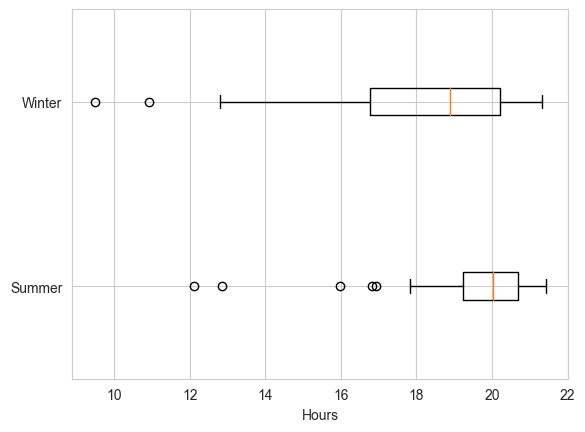

In [650]:
# range of running hours by season
fig, ax = plt.subplots()
hours_data = [time_as_number(summer_runs), time_as_number(winter_runs)]
ax.boxplot(hours_data, vert=False)
plt.yticks([1, 2], ["Summer", "Winter"])
plt.xlabel("Hours")
plt.show()